# Sentinel-2 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
s2a_msil2a, 
s2b_msil2a


## Background

Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands).
The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery.
Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.
Both of the Sentinel-2 satellites carry an innovative wide swath high-resolution multispectral imager with 13 spectral bands.
For more information on the Sentinel-2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Applications/Observing_the_Earth/Copernicus/Overview4).

Digital Earth Africa (DE Africa) provides [Sentinel 2, Level 2A](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a-processing) surface reflectance data provided by ESA.
Surface reflectance provides standardised optical datasets by using robust physical models to correct for variations in image radiance values due to atmospheric properties, as well as sun and sensor geometry.
The resulting stack of surface reflectance grids are consistent over space and time, which is instrumental in identifying and quantifying environmental change.

DE Africa provides one Sentinel-2 surface reflectance product:

1. **Sentinel-2** (i.e. `s2a_msil2a` & `s2b_msil2a`): These products represent the 'definitive' source of high quality Sentinel-2 surface reflectance data, and are available from the beginning of the Sentinel-2 archive. 

Sentinel-2, Level 2A surface reflectance products have 13 spectral channels and one pixel quality band ([scl](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)):

| Sentinel-2 bands | DEAfrica band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `blue` | 2 | 490 | 10 | 65 |
| Green | `green` | 3 | 560 | 10 | 35 |
| Red | `red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | `water_vapour` | 9 | 945 | 60 | 20 |
| SWIR | `swir_1` | 11 | 1610 | 20 | 90 |
| SWIR | `swir_2` | 12 | 2190 | 20 | 180 |
| SCL  | `scl`    | 13 | N/A

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

!['Sentinel-2 spectral bands'](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)
     

## Description

This notebook will run through loading in Sentinel-2A and Sentinel-2B satellite images.
Topics covered include:

* Using the native `dc.load()` function to load in Sentinel-2 data from a single Sentinel-2 satellite
* Using the `load_ard()` wrapper function to load in a concatenated, sorted, and cloud masked time series from both Sentinel-2A and 2B

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import sys
import datacube

sys.path.append("../Scripts")
from deafrica_datahandling import load_ard, mostcommon_crs
from deafrica_plotting import rgb

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Sentinel_2")

## Load Sentinel-2 data from the datacube

We will load **Sentinel-2** data from the Sentinel-2A and Sentinel-2B satellites using two methods.
Firstly, we will use [dc.load()](../Beginners_guide/03_Loading_data.ipynb) to return a time series of satellite images from a single sensor.
Secondly, we will load a time series using the [load_ard()](../Frequently_used_code/Using_load_ard.ipynb) function, which is a wrapper function around the dc.load module.
This function will load all the images from both Sentinel-2A and Sentinel-2B, combine them, and then apply a cloud mask.
The returned `xarray.Dataset` will contain analysis ready images with the cloudy and invalid pixels masked out.

You can change any of the parameters in the `query` object below to adjust the location, time, projection, or spatial resolution of the returned datasets.
To learn more about querying, refer to the Beginner's guide notebook on [loading data](../Beginners_guide/03_Loading_data.ipynb).

Sentinel-2 data is stored on file with a range of different coordinate reference systems or CRS (i.e. multiple UTM zones). 
The different satellite bands also have different resolutions (10 m, 20 m and 60 m). 
Because of this, all Sentinel-2 queries need to include the following two query parameters:

* `output_crs`: This sets a consistent CRS that all Sentinel-2 data will be reprojected to, regardless of the UTM zone the individual image is stored in.
* `resolution`: This sets the resolution that all Sentinel-2 images will be resampled to. 

> **Note:** Be aware that setting `resolution` to the highest available resolution (i.e. `(-10, 10)`) will downsample the coarser resolution 20 m and 60 m bands, which may introduce unintended artefacts into your analysis.
It is typically best practice to set `resolution` to match the lowest resolution band being analysed. For example, if your analysis uses both 10 m and 20 m resolution bands, set `"resolution": (-20, 20)`.

In [3]:
# Create a query object
query = {
    'x': (-1.9, -2),
    'y': (6.9,7),
    "time": ("2018-01", "2018-02"),
    "resolution": (-10, 10),
    "group_by": "solar_day",
}

### Load Sentinel-2 using `dc.load()`

The two **Sentinel-2** products are:

* `s2a_msil2a`
* `s2b_msil2a`

Here we will load in a time-series of satellite images from only Sentinel-2A.
To load in images from Sentinel-2B, change the `product` variable to `'s2b_msil2a'`.

In [4]:
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='s2a_msil2a', query=query)

#load data
ds = dc.load(product="s2a_msil2a",
             output_crs = output_crs,
             dask_chunks={},
             **query)

print(ds)

<xarray.Dataset>
Dimensions:          (time: 6, x: 1108, y: 1109)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-02T10:33:57.706000 ... 2018-02-21T10:30:53.997000
  * y                (y) float64 7.739e+05 7.739e+05 ... 7.628e+05 7.628e+05
  * x                (x) float64 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
Data variables:
    coastal_aerosol  (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    blue             (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    green            (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    red              (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    red_edge_1       (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    red_edge_2       (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    red_edge_3       (time, y, x) uint16 dask.array<chunksize=(1, 1109, 11

The returned dataset contains all of the bands available for Sentinel-2.

In [5]:
bands = ["blue", "green", "red"]

ds = dc.load(product="s2a_msil2a",
             measurements=bands,
             output_crs=output_crs,
             dask_chunks={},
             **query)

print(ds)

<xarray.Dataset>
Dimensions:  (time: 6, x: 1108, y: 1109)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-02T10:33:57.706000 ... 2018-02-21T10:30:53.997000
  * y        (y) float64 7.739e+05 7.739e+05 7.739e+05 ... 7.628e+05 7.628e+05
  * x        (x) float64 6.105e+05 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
Data variables:
    blue     (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    green    (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    red      (time, y, x) uint16 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
Attributes:
    crs:      epsg:32630


Once the load is complete, we can then analyse or plot the Sentinel-2 data:

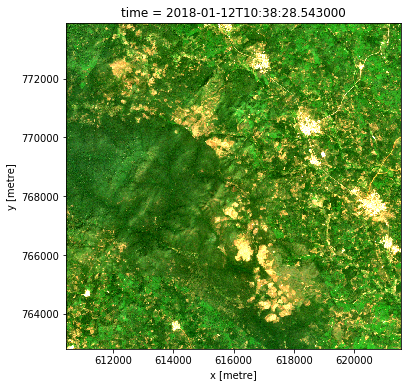

In [6]:
rgb(ds, index=1)

### Load Sentinel-2 using `load_ard`

This function will load images from both Sentinel-2A and Sentinel-2B, concatenate and sort the observations by time, and apply a cloud mask.
The result is an analysis ready dataset.
You can find more information on this function from the [Using load ard](../Frequently_used_code/Using_load_ard.ipynb) notebook.

In [7]:
ds = load_ard(dc=dc,
              products=["s2a_msil2a", "s2b_msil2a"],
              measurements=bands,
              output_crs=output_crs,
              dask_chunks={},
              **query)

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2a_msil2a
    s2b_msil2a
Applying pixel quality/cloud mask
Returning 12 time steps as a dask array
<xarray.Dataset>
Dimensions:  (time: 12, x: 1108, y: 1109)
Coordinates:
  * x        (x) float64 6.105e+05 6.105e+05 6.105e+05 ... 6.215e+05 6.215e+05
  * y        (y) float64 7.739e+05 7.739e+05 7.739e+05 ... 7.628e+05 7.628e+05
  * time     (time) datetime64[ns] 2018-01-02T10:33:57.706000 ... 2018-02-26T10:33:13.735000
Data variables:
    blue     (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    green    (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
    red      (time, y, x) float32 dask.array<chunksize=(1, 1109, 1108), meta=np.ndarray>
Attributes:
    crs:      epsg:32630


In [ ]:
rgb(ds, index=[0,2,-4])

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Feb 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()